In [26]:
import math
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint, NonlinearConstraint

df = pd.read_csv("../Root_Insurance_data.csv")
#copying and pasting numbers without needing to run code again

#_name is the 4 features
_name = ['Currently Insured', 'Number of Vehicles', 'Number of Drivers', 'Marital Status']
#_index keeps track of stuff
#(currently insured, number vehicles, number drivers, marital status)
_index = [['Y', 1, 1, 'M'],
 ['Y', 2, 2, 'M'],
 ['Y', 3, 1, 'S'],
 ['Y', 1, 2, 'S'],
 ['Y', 2, 1, 'M'],
 ['Y', 3, 2, 'M'],
 ['Y', 1, 1, 'S'],
 ['Y', 2, 2, 'S'],
 ['Y', 3, 1, 'M'],
 ['Y', 1, 2, 'M'],
 ['Y', 2, 1, 'S'],
 ['Y', 3, 2, 'S'],
 ['N', 1, 1, 'M'],
 ['N', 2, 2, 'M'],
 ['N', 3, 1, 'S'],
 ['N', 1, 2, 'S'],
 ['N', 2, 1, 'M'],
 ['N', 3, 2, 'M'],
 ['N', 1, 1, 'S'],
 ['N', 2, 2, 'S'],
 ['N', 3, 1, 'M'],
 ['N', 1, 2, 'M'],
 ['N', 2, 1, 'S'],
 ['N', 3, 2, 'S'],
 ['unknown', 1, 1, 'M'],
 ['unknown', 2, 2, 'M'],
 ['unknown', 3, 1, 'S'],
 ['unknown', 1, 2, 'S'],
 ['unknown', 2, 1, 'M'],
 ['unknown', 3, 2, 'M'],
 ['unknown', 1, 1, 'S'],
 ['unknown', 2, 2, 'S'],
 ['unknown', 3, 1, 'M'],
 ['unknown', 1, 2, 'M'],
 ['unknown', 2, 1, 'S'],
 ['unknown', 3, 2, 'S']]

#click = number of clicks for each status
#sold = number of policies sold
#total = number in each category
click = [37, 21, 24, 77, 19, 18, 78, 16, 21, 76, 15, 11, 25, 33, 22, 79, 15, 21, 43, 32, 15, 74, 16, 13, 112, 94, 67, 128, 84, 73, 127, 110, 69, 105, 108, 0]
sold = [11, 8, 5, 24, 6, 2, 38, 3, 4, 24, 4, 4, 14, 15, 8, 32, 6, 11, 25, 15, 9, 31, 5, 3, 59, 26, 26, 55, 41, 32, 69, 42, 25, 57, 44, 0]
total = [274, 317, 267, 282, 284, 276, 290, 304, 294, 295, 266, 270, 300, 296, 286, 283, 263, 326, 271, 316, 265, 275, 272, 291, 294, 306, 256, 303, 268, 277, 280, 288, 287, 294, 284, 0]



#probsold = number sold/10000
#probSoldGivenClick = numbersold/number click
probsold=[]#probably sold
probSoldGivenClick = [] #prob sold given click
for i in range(0,len(click)):
    if click[i] !=0:
        probsold.append(sold[i]/10000)
        probSoldGivenClick.append(sold[i]/click[i])
    else:
        probsold.append(0)
        probSoldGivenClick.append(0)
        
#prRF = pd.read_csv('probabilities.csv')
#probRF = prRF['prob from random forests']
        
#totalrank, total number in each rank, 1 to 5
#clickperrank = clicks in each rank, 1 to 5
totalrank = [1611, 1608, 2401, 2089, 2291]
clickperrank = [848, 462, 351, 168, 49]

#dividedrankmean = average rank for each category
dividedrankmean = [3.5693430656934306, 4.302839116719243, 4.2434456928838955, 2.5106382978723403, 4.264084507042254, 4.3768115942028984, 2.5482758620689654, 4.3256578947368425, 4.316326530612245, 2.559322033898305, 4.349624060150376, 4.325925925925926, 3.5733333333333333, 3.4932432432432434, 4.255244755244755, 2.441696113074205, 4.391634980988593, 4.245398773006135, 3.4354243542435423, 3.632911392405063, 4.305660377358491, 2.4545454545454546, 4.286764705882353, 4.243986254295533, 1.6904761904761905, 1.65359477124183, 2.58984375, 1.683168316831683, 1.7611940298507462, 2.5487364620938626, 1.6214285714285714, 1.7256944444444444, 2.491289198606272, 1.6598639455782314, 1.6866197183098592]
#WARNING, len(dividedrankmean)= 35. This is because the very last category(['unknown', 3, 2, 'S']) is empty
    

    
competitionrate = []#the rate that other companies are bidding for each customer type, assume exponential
competitionrateuni = []#assume uniform
theta = [] # the rate of expected clicks for ads at rank=r.
bid = [] # what we bid for each type of customer

#fill in values
for i in range(0,35):
    competitionrate.append(0) #default 0
    competitionrateuni.append(0) #default 0
    bid.append(10) #default 10
#estimated values for theta
for i in range(0,5):
    theta.append(clickperrank[i]/totalrank[i])

#estimated values for competitionrate. Assume exponential MLE.
for i in range(0, 35):
    competitionrate[i] = -10/(np.log((dividedrankmean[i]-1)/4))
for i in range(0, 35):
    competitionrateuni[i] = 40/(5-dividedrankmean[i])


Here, we define the functions, Expected cost, expected number of policies sold, and the expected cost per policy sold. I assume the model for bids is exponential.

In [2]:
#expectedcost, expectedsold, expected cost per policy sold
def expectedsold(bid):#expected number of policies sold
    for i in range(0, len(bid)):
        if bid[i]<0:
            return 0
    e = 0
    for i in range(0, 35):#35 because click at 36 = 0, lambda will cause errors
        for r in range(1, 6):
            if bid[i]<0:
                e = e +0
            else:
                e = e + total[i]*probSoldGivenClick[i]*theta[r-1]*math.comb(4, r-1)*(np.exp(-bid[i]/competitionrate[i]))**(r-1)*(1-np.exp(-bid[i]/competitionrate[i]))**(5-r)
            #print(e)
    return e
def expectedcost(bid):#expected cost of policy
    e = 0
    for i in range(0, 35):
        for r in range(1, 6):
            if bid[i]<0:
                e = e+0
            else:
                e = e + total[i]*bid[i]*theta[r-1]*math.comb(4, r-1)*(np.exp(-bid[i]/competitionrate[i]))**(r-1)*(1-np.exp(-bid[i]/competitionrate[i]))**(5-r)
        #print(e)
    return e

def costpersold(bid):
    return expectedcost(bid)/expectedsold(bid)
def constraint(bid): #constaining that the expected number of policies sold is more than 400
    return expectedsold(bid)


Some additional functions

In [3]:
#expected clicks

def expectedclick(bid):#expected clicks
    e = 0
    for i in range(0, 35):
        for r in range(1, 6):
            if bid[i]<0:
                e = e+0
            else:
                e = e + click[i]*theta[r-1]*math.comb(4, r-1)*(np.exp(-bid[i]/competitionrate[i]))**(r-1)*(1-np.exp(-bid[i]/competitionrate[i]))**(5-r)
        #print(e)
    return e

I compute the gradient of expectedcost

In [4]:
#expected cost derivative
def grad_cost(bid):
    gradient = []
    for i in range(0,35):
        k = 0
        for r in range(1,6):
            if bid[i]<0:
                k = k+0
            else:
                k = k + click[i]*theta[r-1]*math.comb(4, r-1)*((np.exp(-bid[i]/competitionrate[i]))**(r-1)*(1-np.exp(-bid[i]/competitionrate[i]))**(5-r) + bid[i]*(np.exp(-bid[i]/competitionrate[i]))**(r-2)*(r-1)*(-np.exp(-bid[i]/competitionrate[i])/competitionrate[i])*(1-np.exp(-bid[i]/competitionrate[i]))**(5-r) +bid[i]*(1-np.exp(-bid[i]/competitionrate[i]))**(4-r)*(5-r)*(np.exp(-bid[i]/competitionrate[i])/competitionrate[i])*(np.exp(-bid[i]/competitionrate[i]))**(r-1)) 
        gradient.append(k)
    np.array(gradient)
    return gradient

Here we optimize costpersold()

In [5]:
#hessian is zero matrix if needed
def cons_H(x, v):
    return np.zeros((35,35))
#nonlinar constraint is the constraint function is bounded from 400 to 1000
nonlinear_constraint = NonlinearConstraint(constraint, 400, 1000)#, hess=cons_H)
#linear constraint is each bid is between 1 to 50
lincon = LinearConstraint(np.identity(35), np.linspace(0.01, 0.01, num=35), np.linspace(50000, 50000, num=35))

In [6]:
nonlin =[]
for i in range(0,10):
    nonlin.append(NonlinearConstraint(constraint, 100+i*100, 100+i*100, hess=cons_H))
    
res = []
print(datetime.datetime.now())
for i in range(0,10):
    res.append(minimize(expectedcost, competitionrate, method='trust-constr', constraints=[lincon, nonlin[i]],  options={'maxiter':5000})) 
    print(datetime.datetime.now())
for i in range(0,10):
    print(expectedcost(res[i].x), expectedsold(res[i].x), costpersold(res[i].x))

2021-05-26 03:13:05.601465


/usr/lib/python3/dist-packages/scipy/optimize/_trustregion_constr/projections.py:182: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +


2021-05-26 03:13:28.531908


/usr/lib/python3/dist-packages/scipy/optimize/_hessian_update_strategy.py:183: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


2021-05-26 03:14:14.585751
2021-05-26 03:15:16.070328
2021-05-26 03:16:08.189009
2021-05-26 03:19:53.795890
2021-05-26 03:26:06.968122
2021-05-26 03:37:17.468159
2021-05-26 03:53:16.475833
2021-05-26 04:09:06.901736
2021-05-26 04:24:55.094361
33.96841100112909 99.99999999999997 0.339684110011291
644.9672914434103 199.99999999999997 3.224836457217052
1889.1481206645906 300.0 6.297160402215302
3761.859313508475 399.9999999999999 9.404648283771191
6311.57098869516 499.9999999999997 12.623141977390327
9623.238740317436 600.0 16.038731233862393
13816.51853809546 699.999999933377 19.737883627729225
19098.125543193484 800.0000000000127 23.872656928991475
25534.99959141661 899.9999999999989 28.372221768240713
36090.91203633987 1000.0000000000002 36.09091203633986


In [7]:
print(expectedcost(res[3].x), expectedsold(res[3].x), costpersold(res[3].x))
for i in range(0,len(res)):
    print(res[i].execution_time, res[i].niter, res[i].success)
    print(expectedcost(res[i].x), expectedsold(res[i].x), costpersold(res[i].x))

3761.859313508475 399.9999999999999 9.404648283771191
22.76661467552185 157 True
33.96841100112909 99.99999999999997 0.339684110011291
45.92473888397217 269 True
644.9672914434103 199.99999999999997 3.224836457217052
61.344897985458374 345 True
1889.1481206645906 300.0 6.297160402215302
51.99087572097778 345 True
3761.859313508475 399.9999999999999 9.404648283771191
225.4765899181366 1499 True
6311.57098869516 499.9999999999997 12.623141977390327
373.01617193222046 2328 True
9623.238740317436 600.0 16.038731233862393
670.3707628250122 5001 False
13816.51853809546 699.999999933377 19.737883627729225
958.8748323917389 5001 False
19098.125543193484 800.0000000000127 23.872656928991475
950.2957923412323 5001 False
25534.99959141661 899.9999999999989 28.372221768240713
948.0617001056671 5001 False
36090.91203633987 1000.0000000000002 36.09091203633986


Going to run gradient descent on expectedcost

In [8]:
#code modified from https://stackabuse.com/gradient-descent-in-python-implementation-and-theory/

# Make threshold a -ve value if you want to run exactly
# max_iterations.
def gradient_descent(max_iterations,threshold,w_init,
                     obj_func,grad_func,
                     learning_rate=0.05,momentum=0.8):
    
    w = w_init
    w_history = w
    f_history = obj_func(w)
    delta_w = np.zeros(w.shape)
    i = 0
    diff = 1.0e10
    
    while  i<max_iterations and diff>threshold:
        for i in range(0,len(delta_w)-1):
            delta_w[i] = -learning_rate*grad_func(w)[i] + momentum*delta_w[i]
        w = w+delta_w
        
        # store the history of w and f
        w_history = np.vstack((w_history,w))
        f_history = np.vstack((f_history,obj_func(w)))
        
        # update iteration number and diff between successive values
        # of objective function
        i+=1
        diff = np.absolute(f_history[-1]-f_history[-2])
    
    return w_history,f_history

resgrad = gradient_descent(10000, 0.05, np.array(bid), expectedcost, grad_cost)

In [9]:
resgrad

(array([[ 10.        ,  10.        ,  10.        , ...,  10.        ,
          10.        ,  10.        ],
        [  9.58239654,   9.88602125,   9.85980174, ...,   8.43398452,
           6.78041245,  10.        ],
        [  8.84684355,   9.68190297,   9.60905733, ...,   5.80942034,
           1.46039145,  10.        ],
        ...,
        [ -3.45852742,  -0.70806556,  -0.8891038 , ..., -12.11551484,
         -23.53297762,  10.        ],
        [ -3.45853094,  -0.70816324,  -0.88913702, ..., -12.11551775,
         -23.53298154,  10.        ],
        [ -3.45853375,  -0.70824139,  -0.88916359, ..., -12.11552007,
         -23.53298468,  10.        ]]),
 array([[18659.04645091],
        [13081.51243895],
        [ 7141.54770149],
        [ 5072.25691926],
        [ 4300.05548239],
        [ 3925.36188376],
        [ 3583.98549111],
        [ 3283.14945944],
        [ 3025.40149851],
        [ 2810.40284112],
        [ 2628.7948861 ],
        [ 2475.4620273 ],
        [ 2344.3815757 ],

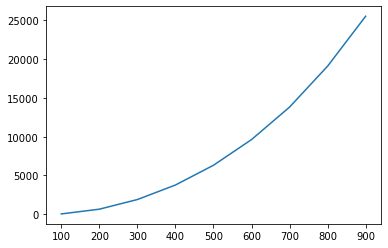

In [10]:
x = [100+i*100 for i in range(0,9)]
y = [expectedcost(res[i].x) for i in range(0,9)]

plt.plot(x,y)
plt.show()

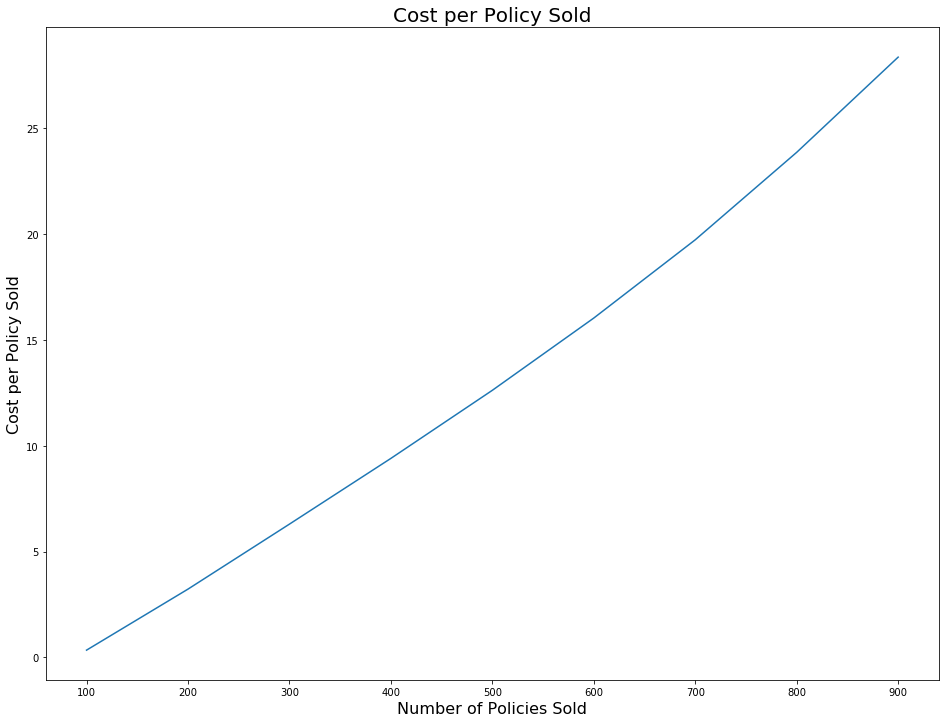

In [11]:
x = [100+i*100 for i in range(0,9)]
y = [costpersold(res[i].x) for i in range(0,9)]

plt.figure(figsize = (16,12))
plt.plot(x,y)
plt.xlabel("Number of Policies Sold", fontsize = 16)
plt.ylabel("Cost per Policy Sold", fontsize = 16)
plt.title("Cost per Policy Sold", fontsize = 20)

plt.show()

In [12]:
currentinsured, numcars, numdrivers, married = [], [],[],[]

for i in range(0, len(_index)):
    currentinsured.append(_index[i][0])
    numcars.append(_index[i][1])
    numdrivers.append(_index[i][2])
    married.append(_index[i][3])

optimizedbids = pd.DataFrame({"Currently Insured":currentinsured[:-1],
                              "Number of Vehicles":numcars[:-1],
                              'Number of Drivers':numdrivers[:-1],
                              'Marital Status':married[:-1],
                             'Estimated Competition Average':competitionrate,
                             'Bids to get 100 Sales':res[0].x,
                             'Bids to get 200 Sales':res[1].x,
                             'Bids to get 300 Sales':res[2].x,
                             'Bids to get 400 Sales':res[3].x,
                             'Bids to get 500 Sales':res[4].x,
                             'Bids to get 600 Sales':res[5].x,
                             'Bids to get 700 Sales':res[6].x,
                             'Bids to get 800 Sales':res[7].x,
                             'Bids to get 900 Sales':res[8].x,
                             'Bids to get 1000 Sales':res[9].x,})


In [13]:
optimizedbids

,Currently Insured,Number of Vehicles,Number of Drivers,Marital Status,Estimated Competition Average,Bids to get 100 Sales,Bids to get 200 Sales,Bids to get 300 Sales,Bids to get 400 Sales,Bids to get 500 Sales,Bids to get 600 Sales,Bids to get 700 Sales,Bids to get 800 Sales,Bids to get 900 Sales,Bids to get 1000 Sales
0,Y,1,1,M,22.591513,0.010000,0.353671,1.251078,2.190471,3.240828,4.457002,5.897781,7.674752,9.724290,0.010104
1,Y,2,2,M,52.216070,0.010000,0.010001,0.578255,1.772479,3.096585,4.616924,6.408077,8.620161,11.204204,16.534824
2,Y,3,1,S,47.696700,0.010000,0.010000,0.010003,0.127481,0.849548,1.675054,2.642337,0.010566,5.207349,8.046395
3,Y,1,2,S,10.269449,0.010000,0.964439,1.927218,2.950611,4.092135,5.379431,6.828981,8.492902,10.257232,13.372006
4,Y,2,1,M,49.184754,0.010000,0.010001,0.219927,1.209558,2.305659,3.562402,5.040534,6.863090,8.989788,13.382794
5,Y,3,2,M,59.044979,0.010000,0.010000,0.010002,0.010004,0.010014,0.010024,0.020256,0.561967,0.012979,0.010169
6,Y,1,1,S,10.535716,0.173940,1.764792,3.302816,4.910869,6.632507,8.476090,10.445516,12.595160,14.771463,18.413984
7,Y,2,2,S,54.163305,0.010000,0.010000,0.010002,0.010014,0.270587,1.013081,1.881963,2.946285,4.178605,6.707393
8,Y,3,1,M,53.351357,0.010000,0.010000,0.010003,0.010016,0.348358,1.102674,1.985486,3.067109,4.319982,0.010051
9,Y,1,2,M,10.615224,0.010000,0.967595,1.942090,2.977928,4.134553,5.441364,6.916317,8.613502,10.417234,13.610292


In [14]:
optimizedbids.to_csv("optimizedbidsexp.csv", index=False)

Now I find the optimized bids assuming the model is uniformly distributed. First, the functions.

In [15]:
def expectedsolduni(bid):#expected number of policies sold
    for i in range(0, len(bid)):
        if bid[i]<0:
            return 0
    e = 0
    for i in range(0, 35):#35 because click at 36 = 0, lambda will cause errors
        for r in range(1, 6):
            if bid[i]<0:
                e = e +0
            else:
                e = e + total[i]*probSoldGivenClick[i]*theta[r-1]*math.comb(4, r-1)*(1- bid[i]/competitionrateuni[i])**(r-1)*(bid[i]/competitionrateuni[i])**(5-r)
            #print(e)
    return e

def expectedcostuni(bid):#expected cost of policy
    e = 0
    for i in range(0, 35):
        for r in range(1, 6):
            if bid[i]<0:
                e = e+0
            else:
                e = e + total[i]*bid[i]*theta[r-1]*math.comb(4, r-1)*(1- bid[i]/competitionrateuni[i])**(r-1)*(bid[i]/competitionrateuni[i])**(5-r)
        #print(e)
    return e

def constraintuni(bid): #constaining that the expected number of policies sold is more than 400
    for i in range(0, len(bid)):
        if bid[i]<0:
            return 0
    e = 0
    for i in range(0, 35):#35 because click at 36 = 0, lambda will cause errors
        for r in range(1, 6):
            if bid[i]<0:
                e = e +0
            else:
                e = e + total[i]*probSoldGivenClick[i]*theta[r-1]*math.comb(4,r-1)*(1- bid[i]/competitionrateuni[i])**(r-1)*(bid[i]/competitionrateuni[i])**(5-r)
            #print(e)
    return e

In [16]:
nonlinuni =[]
for i in range(0,10):
    nonlinuni.append(NonlinearConstraint(constraintuni, 100+i*100, 100+i*100, hess=cons_H))

In [17]:
result_uni  = []
print(datetime.datetime.now())
for i in range(0,10):
    result_uni.append(minimize(expectedcostuni, competitionrateuni, method='trust-constr', constraints=[lincon, nonlinuni[i]],))
    print(datetime.datetime.now())

2021-05-26 04:25:00.824079
2021-05-26 04:25:14.708865
2021-05-26 04:25:31.807700
2021-05-26 04:26:34.431609
2021-05-26 04:27:18.165579
2021-05-26 04:28:22.111770
2021-05-26 04:29:27.507528
2021-05-26 04:29:36.699926
2021-05-26 04:29:53.672226
2021-05-26 04:30:14.422086
2021-05-26 04:30:35.451769


In [18]:
for i in range(0,10):
    print(expectedcostuni(result_uni[i].x), expectedsolduni(result_uni[i].x), expectedcostuni(result_uni[i].x)/expectedsolduni(result_uni[i].x))

65.46589663386851 99.99999999999 0.6546589663387506
1048.4176558924369 200.00000000000003 5.242088279462184
2774.5359044475854 300.00000000001467 9.248453014824833
5032.491978185759 400.00000000000006 12.581229945464395
7710.440709791023 500.00000000001756 15.420881419581505
10740.759894809737 600.0000000000242 17.90126649134884
14078.222476735686 699.9999999999903 20.111746395336972
17690.47263618005 799.9999999999997 22.11309079522507
21553.030423436074 900.0 23.947811581595637
25646.671471003116 1000.0000000000001 25.646671471003113


In [19]:
bidsuni = pd.DataFrame({"Currently Insured":currentinsured[:-1],
                              "Number of Vehicles":numcars[:-1],
                              'Number of Drivers':numdrivers[:-1],
                              'Marital Status':married[:-1],
                             'Estimated Competition Average':competitionrateuni,
                             'Bids to get 100 Sales':result_uni[0].x,
                             'Bids to get 200 Sales':result_uni[1].x,
                             'Bids to get 300 Sales':result_uni[2].x,
                             'Bids to get 400 Sales':result_uni[3].x,
                             'Bids to get 500 Sales':result_uni[4].x,
                             'Bids to get 600 Sales':result_uni[5].x,
                        'Bids to get 700 Sales':result_uni[6].x,
                        'Bids to get 800 Sales':result_uni[7].x,
                        'Bids to get 900 Sales':result_uni[8].x,
                        'Bids to get 1000 Sales':result_uni[9].x,})

In [20]:
bidsuni.to_csv('optimizedbidsuni.csv')

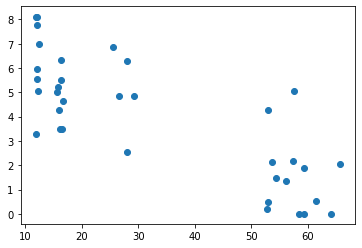

In [21]:
x = bidsuni['Estimated Competition Average']
y = bidsuni['Bids to get 400 Sales']

plt.scatter(x,y)
plt.show()

In [22]:
bidsuni

,Currently Insured,Number of Vehicles,Number of Drivers,Marital Status,Estimated Competition Average,Bids to get 100 Sales,Bids to get 200 Sales,Bids to get 300 Sales,Bids to get 400 Sales,Bids to get 500 Sales,Bids to get 600 Sales,Bids to get 700 Sales,Bids to get 800 Sales,Bids to get 900 Sales,Bids to get 1000 Sales
0,Y,1,1,M,27.959184,0.010000,0.838956,1.792429,2.534501,3.155865,3.699481,4.189690,4.640413,5.060776,5.457008
1,Y,2,2,M,57.375566,0.010000,0.075050,1.268791,2.185471,2.943860,3.600248,4.186258,4.720306,5.214303,5.676459
2,Y,3,1,S,52.871287,0.010000,0.010001,0.010019,0.193961,0.598989,0.947649,1.257313,1.538157,1.796731,2.037580
3,Y,1,2,S,16.068376,0.047301,1.528577,2.604008,3.473006,4.221693,4.890429,5.502026,6.069541,6.601498,7.103823
4,Y,2,1,M,54.354067,0.010000,0.010003,0.735693,1.490959,2.114534,2.653188,3.133283,3.570063,3.973446,4.350262
5,Y,3,2,M,64.186047,0.010000,0.010000,0.010004,0.010006,0.010015,0.010032,0.010016,0.010019,0.010022,0.010027
6,Y,1,1,S,16.315049,0.482568,2.910791,4.783493,6.340537,7.685710,8.874014,9.942556,10.915984,11.812253,12.644828
7,Y,2,2,S,59.317073,0.010000,0.010000,0.010007,0.010017,0.011067,0.309610,0.586197,0.836791,1.067242,1.281710
8,Y,3,1,M,58.507463,0.010000,0.010000,0.010008,0.010025,0.078461,0.395309,0.676551,0.931385,1.165758,1.383883
9,Y,1,2,M,16.388889,0.042897,1.542908,2.631126,3.509982,4.266914,4.942939,5.561178,6.134914,6.672770,7.180758


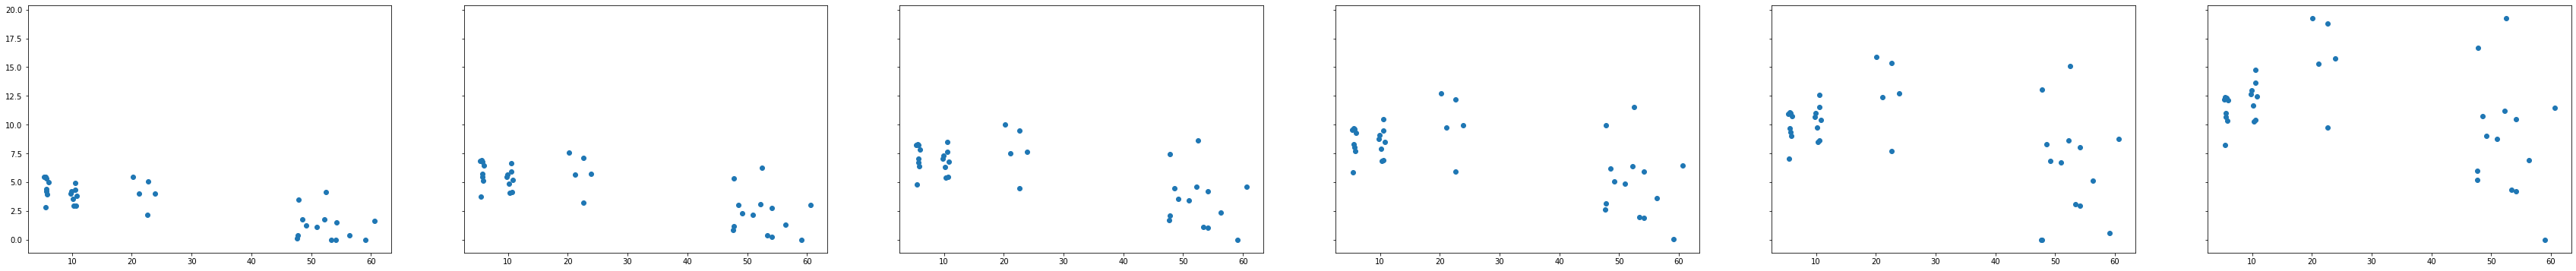

In [23]:
x = optimizedbids['Estimated Competition Average']
y1 = optimizedbids['Bids to get 400 Sales']
y2 = optimizedbids['Bids to get 500 Sales']
y3 = optimizedbids['Bids to get 600 Sales']
y4 = optimizedbids['Bids to get 700 Sales']
y5 = optimizedbids['Bids to get 800 Sales']
y6 = optimizedbids['Bids to get 900 Sales']

fig, axs = plt.subplots(1, 6, figsize = (60,6), sharey=True)

axs[0].scatter(x, y1)
axs[1].scatter(x, y2)
axs[2].scatter(x, y3)
axs[3].scatter(x, y4)
axs[4].scatter(x, y5)
axs[5].scatter(x, y6)

plt.show()

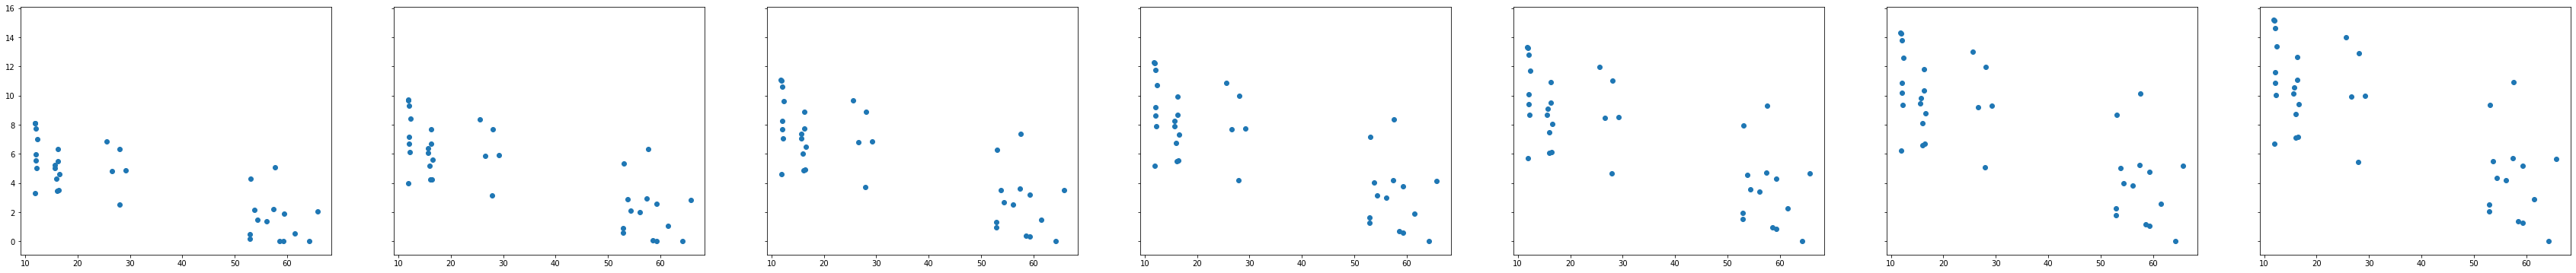

In [24]:
x = bidsuni['Estimated Competition Average']
y1 = bidsuni['Bids to get 400 Sales']
y2 = bidsuni['Bids to get 500 Sales']
y3 = bidsuni['Bids to get 600 Sales']
y4 = bidsuni['Bids to get 700 Sales']
y5 = bidsuni['Bids to get 800 Sales']
y6 = bidsuni['Bids to get 900 Sales']
y7 = bidsuni['Bids to get 1000 Sales']

fig, axs = plt.subplots(1, 7, figsize = (60,6), sharey=True)

axs[0].scatter(x, y1)
axs[1].scatter(x, y2)
axs[2].scatter(x, y3)
axs[3].scatter(x, y4)
axs[4].scatter(x, y5)
axs[5].scatter(x, y6)
axs[6].scatter(x, y7)

plt.show()

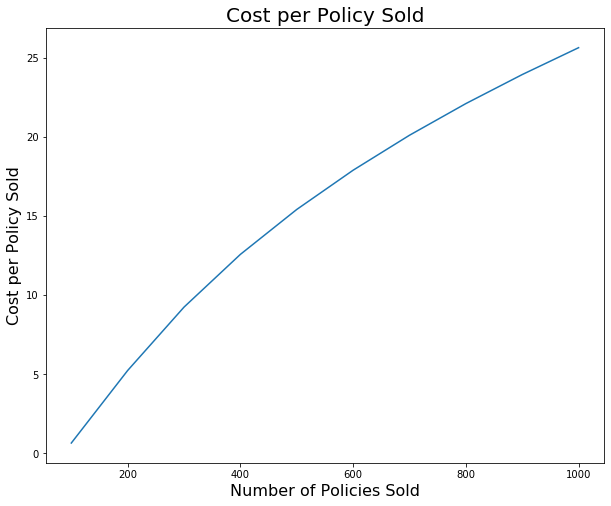

In [25]:
x = [100+i*100 for i in range(0,10)]
y = [expectedcostuni(result_uni[i].x)/expectedsolduni(result_uni[i].x) for i in range(0,10)]

plt.figure(figsize = (10,8))
plt.plot(x,y)
plt.xlabel("Number of Policies Sold", fontsize = 16)
plt.ylabel("Cost per Policy Sold", fontsize = 16)
plt.title("Cost per Policy Sold", fontsize = 20)

plt.show()